# ALAS1 Expression Classifier

# This notebook uses Random Forest to classify strains into high, medium, or low ALAS1_Combined expression levels from a 1000-row Bgee RNA-Seq dataset.
# Addresses community feedback on outliers by analyzing their classification.

In [1]:
# import needed libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns

# Load dataset

In [21]:
df = pd.read_csv('df_clean.csv')
df.head()

,Gene name,Expression level,Read count,Strain,Time_min,Expression_combined,Strain_Encoded,Cluster,ALAS1_combined
0,ALAS1,0.036724,0.186657,White,0,0.111691,1,1,0.111691
1,ALAS1,0.059476,0.308144,White,1,0.183810,1,1,0.183810
2,ALAS1,0.027832,0.138351,Black or African American,2,0.083092,0,2,0.083092
3,ALAS1,0.043375,0.100492,confidential_restricted_data,3,0.071933,2,0,0.071933
4,ALAS1,0.047138,0.142381,White,4,0.094760,1,1,0.094760


# Preprocess: Ensure numeric columns

In [22]:
df[['Expression level', 'Read count']] = df[['Expression level', 'Read count']].apply(pd.to_numeric, errors='coerce')
df.dropna(inplace=True)

# Normalize and compute Expression_combined

In [23]:
scaler = MinMaxScaler()
df['Expression level'] = scaler.fit_transform(df[['Expression level']])
df['Read count'] = scaler.fit_transform(df[['Read count']])
df['ALAS1_combined'] = (df['Expression level'] + df['Read count'])/2

# Encode Strain_name

In [24]:
le = LabelEncoder()
df['Strain_Encoded'] = le.fit_transform(df['Strain'])

# Create target: Classify Expression_combined into high, medium, low(using quantiles)

In [ ]:
df['Expression_Levels'] = pd.qcut(df['ALAS1_combined'], q=3, labels=['Low', 'Medium', 'High'])
df['Expression_Levels']

# Features (X) and target (y)

In [26]:
X = df[['Strain_Encoded', 'Expression level', 'Read count']]
y = df['Expression_Levels']
X.head()
y.value_counts()


Expression_Levels
Low       321
Medium    321
High      321
Name: count, dtype: int64

# Split data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_test

# Train Random Forest Classifier

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# Predict

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred

# Evaluate

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.9326
F1-Score: 0.9338


# Add cross validation

In [ ]:
from sklearn.model_selection import cross_val_score
scores= cross_val_score(rf, X, y, cv=5)
print(f"Cross-validation scores: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

Cross-validation scores: 0.9668 (+/- 0.0268)


# Confusion Matrix

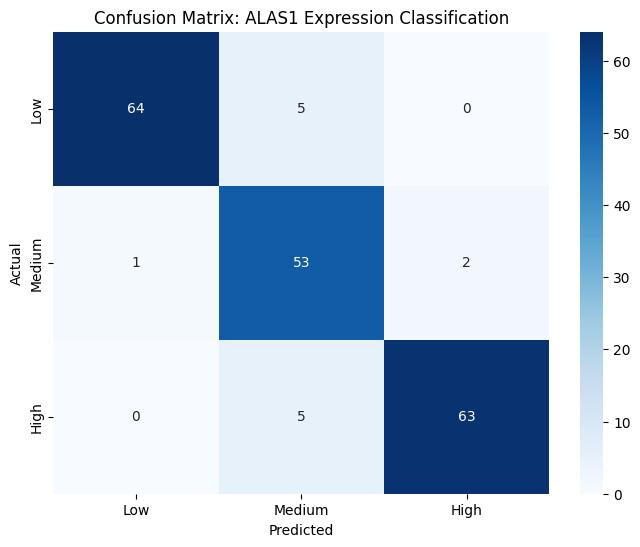

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=['Low', 'Medium', 'High'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: ALAS1 Expression Classification')
plt.savefig('alas1_confusion_matrix.png')
plt.show()

# Feature Importance

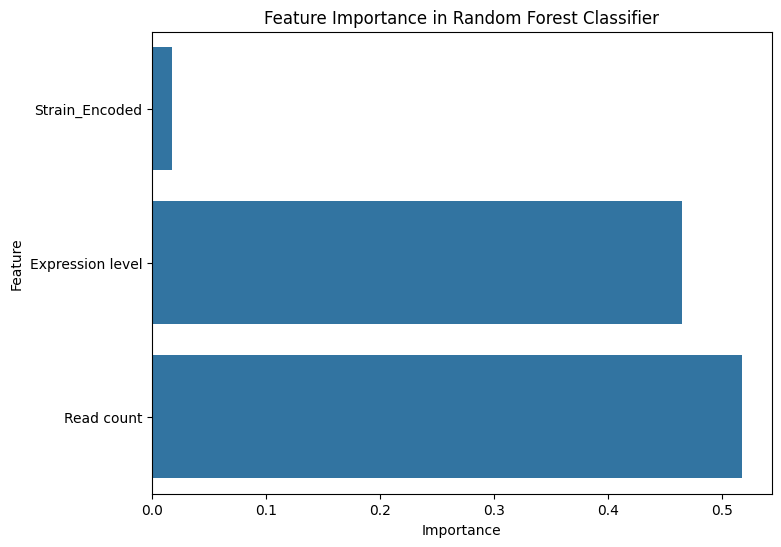

In [ ]:
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
plt.figure(figsize=(8, 6))
sns.barplot(x= 'Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance in Random Forest Classifier')
plt.savefig('alas1_feature_importance.png')
plt.show()

# Analyse outliers(from previous feedback, using IQR on ALAS1 Expression_combined)

In [34]:
Q1 = df['ALAS1_combined'].quantile(0.25)
Q3= df['ALAS1_combined'].quantile(0.75)
IQR = Q3 -Q1
outliers = df[(df['ALAS1_combined'] < Q1 -3 * IQR) | (df['ALAS1_combined'] > Q3 + 3 * IQR)]
outliers['Predicted_level'] = rf.predict(outliers[['Strain_Encoded', 'Expression level', 'Read count']])
print("Outliers and Predicted levels:", outliers[['Strain', 'ALAS1_combined', 'Expression level', 'Predicted_level']])
print(f"outliers:", len(outliers))

Outliers and Predicted levels:                            Strain  ALAS1_combined  Expression level  \
7    confidential_restricted_data        0.679477          0.435965   
449  confidential_restricted_data        0.660657          0.739460   
450  confidential_restricted_data        0.699165          0.668752   
509  confidential_restricted_data        0.681257          0.462449   
807  confidential_restricted_data        0.659214          0.337318   
887  confidential_restricted_data        0.658431          0.391451   

    Predicted_level  
7              High  
449            High  
450            High  
509            High  
807            High  
887            High  
outliers: 6


C:\Users\hisript\AppData\Local\Temp\ipykernel_11240\2169178208.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers['Predicted_level'] = rf.predict(outliers[['Strain_Encoded', 'Expression level', 'Read count']])


# Analyse the outliers

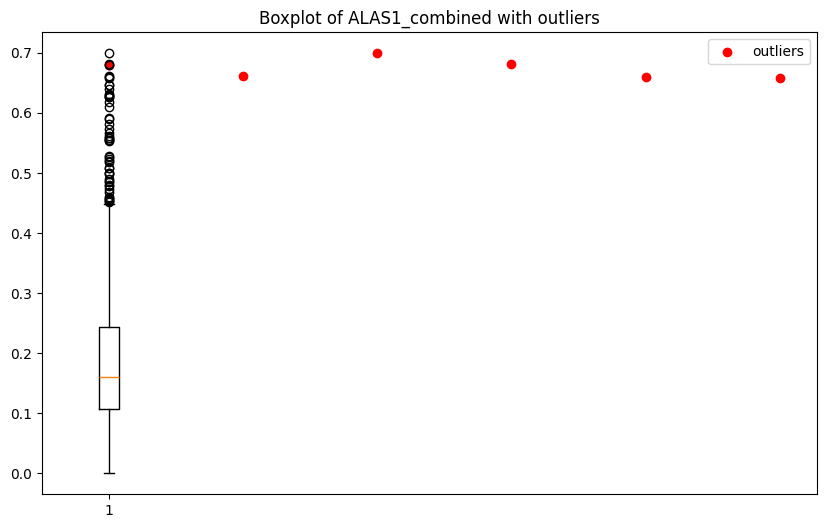

In [36]:
# visualise their distribution
plt.figure(figsize=(10, 6))
plt.boxplot(df['ALAS1_combined'])
plt.scatter(range(1, len(outliers) + 1), outliers['ALAS1_combined'], color='red', label='outliers')
plt.title('Boxplot of ALAS1_combined with outliers')
plt.legend()
plt.savefig('alas1_combined_classfier_boxplot_with_outliers.png')
plt.show()

# Test outliers impact and eradicate it if neccesary

In [37]:
df_no_outliers = df[~((df['ALAS1_combined'] < Q1 - 3 * IQR) | (df['ALAS1_combined']> Q3 + 3 *IQR))]
df_no_outliers = df_no_outliers.reset_index(drop= True)
X = df_no_outliers[['Strain_Encoded', 'Expression level', 'Read count']]
y = df_no_outliers['Expression_Levels']
X.head()
y.value_counts()

Expression_Levels
Low       321
Medium    321
High      315
Name: count, dtype: int64

# Refit the random forest and check the output without outliers

Accuracy: 0.9583
F1-Score: 0.9583
Cross-validation scores: 0.9624 (+/- 0.0244)


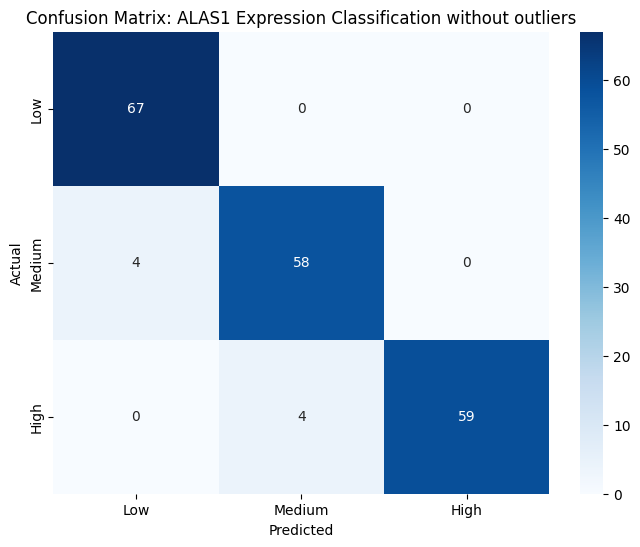

In [40]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#fit random forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
#evaluate
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
#cross validation
from sklearn.model_selection import cross_val_score
scores= cross_val_score(rf, X, y, cv=5)
print(f"Cross-validation scores: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
#confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['Low', 'Medium', 'High'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: ALAS1 Expression Classification without outliers')
plt.savefig('alas1_confusion_matrix_without_outliers.png')
plt.show()

# feature importance without outliers

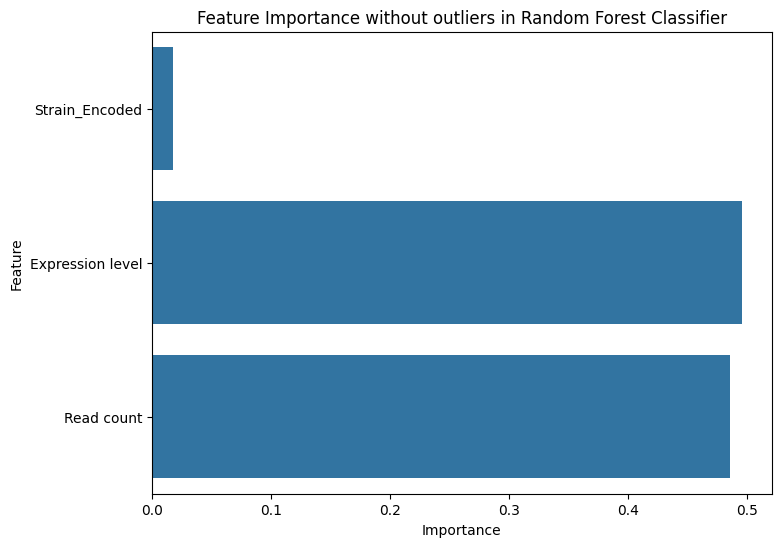

In [39]:
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
plt.figure(figsize=(8, 6))
sns.barplot(x= 'Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance without outliers in Random Forest Classifier')
plt.savefig('alas1_feature_importance_without_outliers.png')
plt.show()

# Save updated dataset with predictions

In [41]:
df_test = X_test.copy()
df_test['Expression_Level_Actual'] = y_test
df_test['Expression_Level_Predicted'] = y_pred
df_test.to_csv('alas1_expression_data_without_outliers.csv', index=False)